# Social Good Hackathon - Covid19 and Texas Counties

# Data Models

### Load cleaned and combined data, check features for corrlation and variance, and run and evaluate regression models.

Load common libraries.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load data science libraries.

In [124]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [125]:
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker import get_execution_role

In [126]:
role = get_execution_role()
input_bucket = 'texas-counties-covid19'

## Load features 

Read csv file with features and target data.

In [127]:
in_data_key = 'combined_data.csv'
data_location = 's3://{}/{}'.format(input_bucket, in_data_key)
features=pd.read_csv(data_location, index_col='County')
print(features.shape)
features.info()

(254, 126)
<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, Anderson to Zavala
Columns: 126 entries, Median Age to Policy Score
dtypes: float64(120), int64(6)
memory usage: 252.0+ KB


In [128]:
features.isnull().sum()

Median Age                            0
% High School Graduate or Higher      0
% Bachelor s Degree or Higher         0
Unemployment Rate (%)                 0
Ethnicity: % Hispanic                 0
                                   ... 
% Severe Housing Problems             0
% Drive Alone                         0
% Long Commute - Drives Alone         0
Yes                                   0
Policy Score                        109
Length: 126, dtype: int64

## Load target data

In [129]:
in_data_key = 'Texas COVID-19 Fatality Count_min.csv'
data_location = 's3://{}/{}'.format(input_bucket, in_data_key)
target=pd.read_csv(data_location)
print(target.shape)
target.head()

(254, 4)


,County,COVID cases Aug_4,COVID deaths Aug_4,Unnamed: 3
0,Anderson,2329,9,NaN
1,Andrews,268,6,NaN
2,Angelina,1745,36,NaN
3,Aransas,158,12,NaN
4,Archer,20,0,NaN


In [130]:
target['County']=target['County'].str.strip(' ')
target['County']=target['County'].str.replace(' ', '')
target['County']=target['County'].str.title()
target.sort_values(by='County', inplace=True)
target.set_index('County', inplace=True)
target=target.iloc[:, :2]

Calculate additional target data.

In [131]:
target['deaths per case']=target['COVID deaths Aug_4']/target['COVID cases Aug_4']
target['deaths per 1000']=target['COVID deaths Aug_4']/(features['Population']/1000)
target['cases per 1000']=target['COVID cases Aug_4']/(features['Population']/1000)
target.head()

,COVID cases Aug_4,COVID deaths Aug_4,deaths per case,deaths per 1000,cases per 1000
County,,,,,
Anderson,2329,9,0.003864,0.155885,40.339482
Andrews,268,6,0.022388,0.320770,14.327720
Angelina,1745,36,0.020630,0.415153,20.123393
Aransas,158,12,0.075949,0.510421,6.720544
Archer,20,0,0.000000,0.000000,2.338361


In [132]:
target.isnull().sum()

COVID cases Aug_4     0
COVID deaths Aug_4    0
deaths per case       4
deaths per 1000       0
cases per 1000        0
dtype: int64

In [133]:
target.fillna(0, inplace=True)
target.replace(np.inf, 0, inplace=True)

## Feature Selection

Check for highly correlated feature pairs.

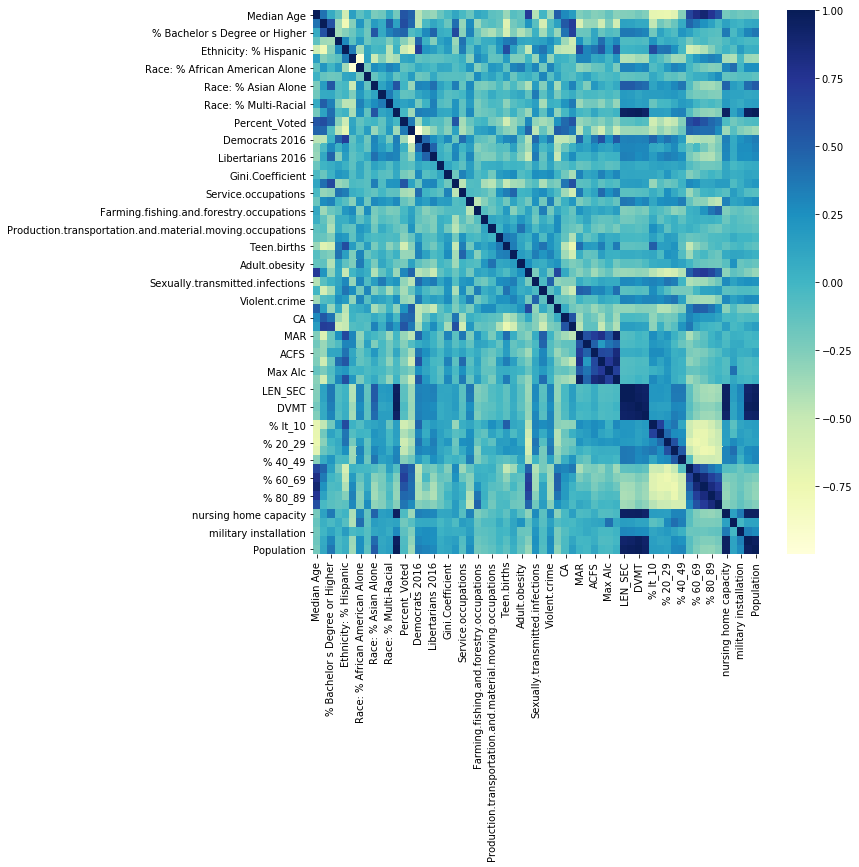

In [134]:
features_df1=pd.concat([features.iloc[:, :60], features.loc[:,'Population']], axis=1)
features_df1_corr=features_df1.corr()
plt.figure(figsize=(10,10))
sns.heatmap(features_df1_corr, cmap="YlGnBu")

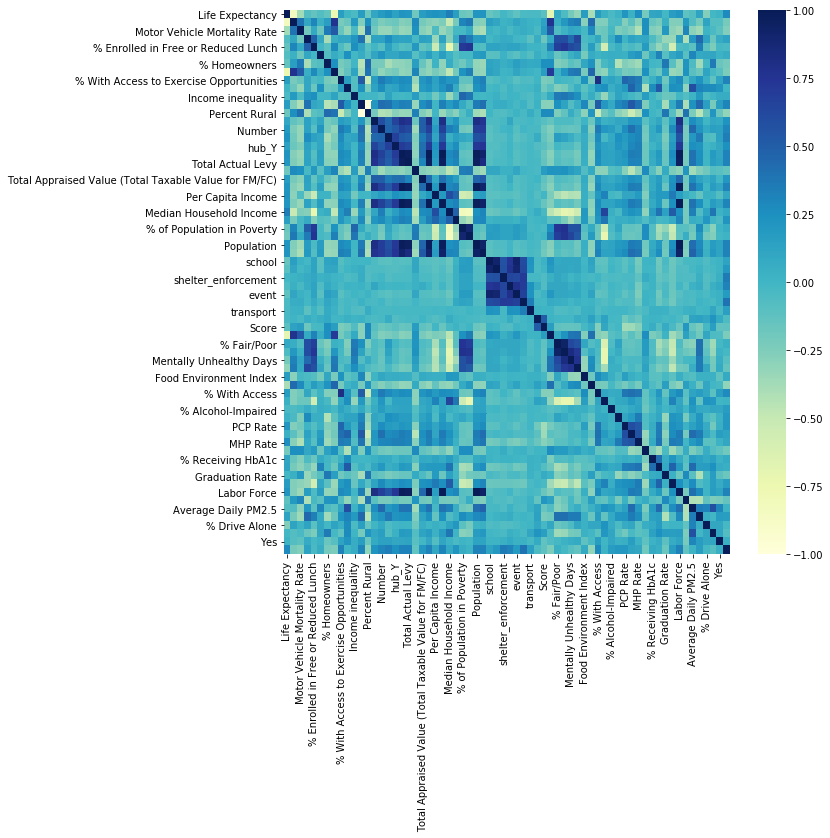

In [135]:
features_df2=features.iloc[:, 60:]
features_df2_corr=features_df2.corr()
plt.figure(figsize=(10,10))
sns.heatmap(features_df2_corr, cmap="YlGnBu")

#### Drop features that are highly correlated

In [136]:
features=features.drop(['Percent Rural', '% of Population Under 18 in Poverty', 'Votes', 'event',
                        'DVMT', 'Total Actual Levy', 'Mixedness',
                        'Total Personal Income', 'Physically Unhealthy Days', '% over_90', 'Population Density',
                        'nursing home capacity', 'Total Personal Income', 'Labor Force',
                        'Total Appraised Value (Total Taxable Value for County Tax Purposes)', 'school'], axis=1)

In [137]:
features.shape

(254, 111)

In [138]:
cols=features.columns

## Split into train and test, replace null values with medians, and scale

In [139]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

In [140]:
X_train=X_train.apply(lambda x: x.fillna(x.median()))
X_test=X_test.apply(lambda x: x.fillna(x.median()))

In [141]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

## Regression Models

### Loop running Linear Regression, Ridge, Lasso, Decision Tree Regressor, Random Forest Regressor, Support Vector Regressor, and Elastic Net with each target

In [142]:
lin_reg = LinearRegression()
lin_regular = Ridge(alpha=.5)
lin_lasso = Lasso(alpha=100,max_iter=100000, normalize=True)
tree_reg = DecisionTreeRegressor(random_state=44)
forest_reg = RandomForestRegressor(random_state=44, n_estimators=100)
SVR_reg = SVR(gamma="auto")
EN_reg = ElasticNet(alpha=.1, max_iter=100000)

model_dict = {"Linear Regression":lin_reg, "Linear Regression - Ridge": lin_regular, "Linear Regression - Lasso":lin_lasso,
             "Decision Tree Regressor": tree_reg, "Random Forest Regressor": forest_reg, "Support Vector Regression": SVR_reg,
             'Elastic Net': EN_reg}

for key, model in model_dict.items():
    print(key)
    for i in range(len(y_train.columns)):
        y = y_train.iloc[:,i]
        model.fit(X_train, y)
        # print results
        print(y_train.columns[i])
        print('Cross Val Score:  ', cross_val_score(model, X_train, y, cv=4, scoring='r2').mean())
        try:
            coef_df=pd.DataFrame(model.coef_, cols, columns=['Coefficient'])
            coef_df=coef_df.sort_values(by=['Coefficient'], ascending=False)
            print(coef_df.head(10))
        except: 
            print('No coefficients for this model')
        print('---------')
    print('------------------------------------------------------------------')

Linear Regression
COVID cases Aug_4
Cross Val Score:   -3385375998.876307
                    Coefficient
Republicans 2016   1.829140e+06
Democrats 2016     1.826609e+06
Libertarians 2016  1.281208e+05
Population         8.511388e+04
Green 2016         7.298714e+04
LN_MILES           3.237214e+04
% 20_29            2.310259e+04
hospital beds      2.132916e+04
% 60_69            1.695157e+04
% 80_89            1.601015e+04
---------
COVID deaths Aug_4
Cross Val Score:   -1024685.2563107859
                         Coefficient
Population               2988.301108
Republicans 2016         2415.879494
Democrats 2016           2414.456630
LEN_SEC                  1212.558748
Libertarians 2016         168.991712
Green 2016                139.630076
Mentally Unhealthy Days    99.923331
Ethnicity: % Hispanic      77.502777
hospital beds              52.729747
customs_Y                  50.339504
---------
deaths per case
Cross Val Score:   -10974808249122.68
                                   

## Ridge with Grid Search

In [143]:
for i in range(len(y_train.columns)):
    y = y_train.iloc[:,i]
    params={'alpha': [.01, .1, 10, 100, 1000], 'max_iter': [10000, 100000, 1000000]}
    ridge=Ridge()
    model=GridSearchCV(estimator=ridge, param_grid=params, cv=4, iid=False, scoring='r2')
    model.fit(X_train, y)
    # print results
    print(y_train.columns[i])
    print('params:  ', model.best_params_)
    print('best score:  ', model.best_score_)
    print('---------')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


COVID cases Aug_4
params:   {'alpha': 0.1, 'max_iter': 10000}
best score:   0.8119621722813328
---------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


COVID deaths Aug_4
params:   {'alpha': 10, 'max_iter': 10000}
best score:   0.6700007352244697
---------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


deaths per case
params:   {'alpha': 100, 'max_iter': 10000}
best score:   0.0007963661433572911
---------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


deaths per 1000
params:   {'alpha': 100, 'max_iter': 10000}
best score:   0.01447375017511135
---------
cases per 1000
params:   {'alpha': 1000, 'max_iter': 10000}
best score:   -1.5177093209747847
---------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


## Lasso with Grid Search

In [144]:
for i in range(len(y_train.columns)):
    y = y_train.iloc[:,i]
    params={'alpha': [.01, .1, 10, 100, 1000], 'max_iter': [100000, 1000000]}
    lasso=Lasso()
    model=GridSearchCV(estimator=lasso, param_grid=params, cv=4, iid=False, scoring='r2')
    model.fit(X_train, y)
    # print results
    print(y_train.columns[i])
    print('best score:  ', model.best_score_)
    print('params:  ', model.best_params_)
    print('---------')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


COVID cases Aug_4
best score:   0.88838652585353
params:   {'alpha': 10, 'max_iter': 100000}
---------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


COVID deaths Aug_4
best score:   0.6623437629518889
params:   {'alpha': 0.1, 'max_iter': 100000}
---------
deaths per case
best score:   -0.011277375959662772
params:   {'alpha': 0.01, 'max_iter': 100000}
---------
deaths per 1000
best score:   0.01089132644663049
params:   {'alpha': 0.01, 'max_iter': 100000}
---------
cases per 1000
best score:   -1.5209552629602565
params:   {'alpha': 100, 'max_iter': 100000}
---------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


## Ensemble models

In [145]:
for i in range(len(y_train.columns)):
    y = y_train.iloc[:,i]
    model1=LinearRegression()
    model2=Lasso(alpha=100, max_iter=100000)
    model3=RandomForestRegressor(n_estimators=10, random_state=101)
    model4=Ridge(alpha=100, max_iter=100000)
    model5=SVR(gamma='auto')
    model6=DecisionTreeRegressor()
    model=VotingRegressor([('lr', model1), ('lasso', model2), ('rfr', model3), 
                           ('ridge', model4),('svr', model5), ('dtr', model6)])
    model.fit(X_train, y)
    # print results
    print(y_train.columns[i])
    print('Cross Val Score:  ', cross_val_score(model, X_train, y, cv=4, scoring='r2').mean())
    print('--------------------')

COVID cases Aug_4
Cross Val Score:   -94038238.21750176
--------------------
COVID deaths Aug_4
Cross Val Score:   -28467.858723023255
--------------------
deaths per case
Cross Val Score:   -304855852773.83026
--------------------
deaths per 1000
Cross Val Score:   -36974150324.8759
--------------------
cases per 1000
Cross Val Score:   -3511563011.534915
--------------------
